# Data Challenge

In [2]:
# Imports required libraries
import pandas as pd
import numpy as np
import tabulate
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sys

###  Versions used in this code

In [3]:
# Finds out the versions of packages used
print "Versions of packages used :"
print "Python Version - {0}" .format(sys.version)
print "\tPandas Version - {0}" .format(pd.__version__)
print "\tPandas Version - {0}" .format(pd.__version__)
print "\tNumPy Version - {0}" .format(np.__version__)
print "\tTabulate Version - {0}" .format(tabulate.__version__)
print "\tSeaborn Version - {0}" .format(sns.__version__)
print "\tMatplotlib Version - {0}" .format(matplotlib.__version__)
print "\tSkLearn Version - {0}" .format(sklearn.__version__)


Versions of packages used :
Python Version - 2.7.11 |Anaconda 2.4.1 (64-bit)| (default, Feb 16 2016, 09:58:36) [MSC v.1500 64 bit (AMD64)]
	Pandas Version - 0.17.1
	Pandas Version - 0.17.1
	NumPy Version - 1.11.0
	Tabulate Version - 0.7.5
	Seaborn Version - 0.7.1
	Matplotlib Version - 1.5.0
	SkLearn Version - 0.17


In [4]:
# Reading source data to dataframe
data=pd.read_csv('challenge.csv')
print "Shape of the Data is : {0}".format(data.shape)

Shape of the Data is : (59976, 19)


## Exploratory Data Analysis

In [5]:
# Function to validate the dataframe
def validate_data_set(df):
    """
    checks the validity variables of a dataset. 
    It looks for datatypes, number of unique values and number of missing values
    df (pandas.dataframe): dataset
    """
    s = []
    i=0
    for col in df.columns:
        s.append((i,col,df[col].dtype,len(pd.unique(df[col])),df[df[col].isnull()].shape[0],
                  round(100*df[df[col].isnull()].shape[0]/float(df.shape[0]),2)))
        i=i+1
    print tabulate.tabulate(s,['S.No.','Label','dtype','# unique values','# missing values','# missing values (%)','Var'])

In [6]:
validate_data_set(data)

  S.No.  Label                          dtype      # unique values    # missing values    # missing values (%)
-------  -----------------------------  -------  -----------------  ------------------  ----------------------
      0  id                             int64                59976                   0                    0
      1  read_rate                      float64               6459                   0                    0
      2  from_domain_hash               object               25481                   0                    0
      3  Domain_extension               object                 399                   5                    0.01
      4  day                            object                   8                   1                    0
      5  campaign_size                  float64               1968                   1                    0
      6  unique_user_cnt                float64               1904                   1                    0
      7  avg_domain

- It can be seen that only one value is missing for most of the variables
- When observed closely, it is the last record that is missing, probably due to incomplete data
- So, Removing the last record from the data instead of imputing

In [7]:
# Ignores the last record
data=data[0:59975]

## Visualisations

### Average read rate across different days

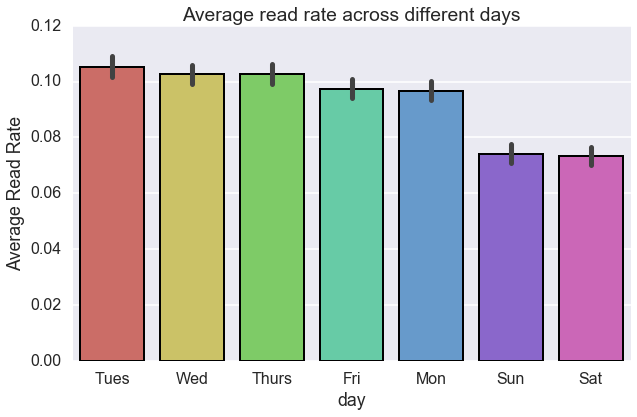

In [8]:
# Prepares data for this plot
dayorder=data.groupby('day').mean().reset_index()[['day','read_rate']].sort_values('read_rate',ascending=False)
arrdayorder=dayorder['day'].values

%matplotlib inline
plt.figure(figsize=(10, 6))
sns.set_context("poster")
ax = sns.barplot(x="day",y='read_rate',data=data,linewidth=2,order=arrdayorder,palette='hls');
ax.set(ylabel='Average Read Rate')
ax.set_title('Average read rate across different days')
plt.show()

- **Average read rate across weekdays is almost constant.  However, on weekends, average read rate is much low**

### Read rate across domains

In [9]:
print "The average read rate of a email campaign is {0}".format(round(np.mean(data['read_rate']),4))

# Prepares data for the next plot
top5domains=pd.DataFrame(data['Domain_extension'].value_counts()).reset_index().sort_values('Domain_extension',ascending=False).head(5)
arrtop5domains=top5domains['index'].values
top5domainData=data.loc[data.Domain_extension.isin(arrtop5domains)]


The average read rate of a email campaign is 0.0946


- **Average read rate is around 10% implies that only 1 in 10 emails are being read in a email campaign on an average**

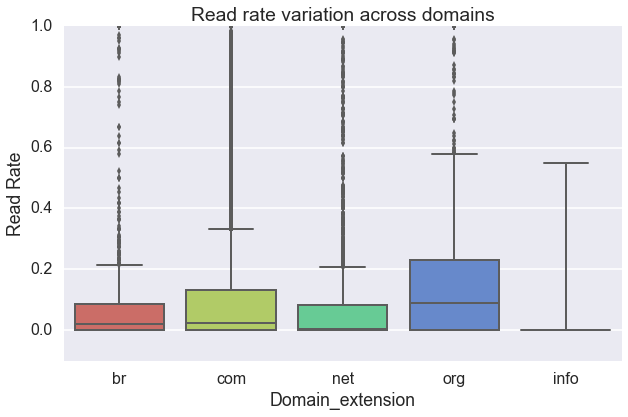

In [10]:
%matplotlib inline
plt.figure(figsize=(10, 6))
sns.set_context("poster")
ax = sns.boxplot(x="Domain_extension",y='read_rate',data=top5domainData,linewidth=2,palette='hls');
ax.set(ylabel='Read Rate')
ax.set_title('Read rate variation across domains')
plt.ylim(-0.1,1)
plt.show()

- Email read rate is maximum for the emails that are going through **'org'** domain 


- There are many email campaigns in which none of the emails are being read
    - Around 50% of the email campaigns through **'br', 'com', 'net'** domains have '0' read rate
    - Around 75% of the email campaigns through **'info'** domain have '0' read rate

### Correlation of read rate across different user types

In [11]:
# Correlation of email campaign read with user types
data.corr()[1:2][['mb_superuser','mb_engper','mb_supersub','mb_engsec','mb_inper','mb_insec','mb_unengsec','mb_idlesub']]


,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
read_rate,0.582466,0.259501,-0.134856,-0.204647,-0.097917,-0.311419,-0.235203,-0.014448


- Read rate is positively correlated with the percentage of the 'super users' and 'engaged personal users' in the email campaigning list

- Read rate is negatively correlated with the percentage of the 'super subscribers', 'engaged secondary accounts', 'unengaged secondary accounts', 'inactive personal', 'inactive secondary', 'idle account' in the email campaigning list


## Data Modification

### Collapsing Domain extension levels

- There are around 400 levels in the 'Domain Extension' variable
- Directly creating dummies for all the levels could lead to 'curse of dimensionality' and 'over fitting'
- Remedy chosen for this problem is to collapse certain levels

In [12]:
# Reviewing the statistics of the domains
domains=pd.DataFrame(data['Domain_extension'].value_counts())
domains=domains.reset_index()
domains.rename(columns={'Domain_extension':'count', 'index':'Domain_extension'}, inplace=True)    #renaming the columns created
domains['% covered']=domains['count']*100/float(data.shape[0])        #to find how much percent of the emails are from each domain
domains['cumulative %']=domains['% covered'].cumsum()                 #to find the cumulative sum of the percentage col
domains=domains.round({'% covered':2,'cumulative %':2})               #rounding of the numbers to two decimals
domains.head(20)

,Domain_extension,count,% covered,cumulative %
0,com,42933,71.58,71.58
1,info,3351,5.59,77.17
2,net,2781,4.64,81.81
3,org,1707,2.85,84.66
4,br,1425,2.38,87.03
5,uk,956,1.59,88.63
6,tw,453,0.76,89.38
7,us,381,0.64,90.02
8,fr,371,0.62,90.63
9,de,296,0.49,91.13


- About 90% of the variation could be covered by the top 9 levels.  A very minimal variation is being captured for every new additional level
- So, the top 9 levels are retained and the remaining levels are collapsed into a new level - 'Other'

In [13]:
# Collapses all the levels other than the top 10 domains
to_be_collapsed = domains[10:]['Domain_extension'].values
others=['Other']*len(to_be_collapsed)
data['Collapsed_Domain_extension']=data['Domain_extension'].replace(to_replace=list(to_be_collapsed),value=others)
print "Updated Domain Extensions :"
print data['Collapsed_Domain_extension'].value_counts()

Updated Domain Extensions :
com      42933
Other     5317
info      3351
net       2781
org       1707
br        1425
uk         956
tw         453
us         381
fr         371
de         296
Name: Collapsed_Domain_extension, dtype: int64


### Creating dummies for categorical variables - 'day' and 'domain'

- Dummies have to be created for categorical variables as the dataset has to undergo Machine Learning algorithm processing

In [14]:
# Creates dummies for the domain and day columns
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['day']=le.fit_transform(data['day'])
data['Collapsed_Domain_extension']=le.fit_transform(data['Collapsed_Domain_extension'])
data=pd.get_dummies(data,columns=['Collapsed_Domain_extension','day'])

C:\Anaconda2\envs\py27\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [15]:
# Exports the dataframe to a file on top of which predictive models in 'R' are built
data.to_csv('updated_data.csv',index=False)

## Model

In [17]:
#function to create submission file
#define target and ID Columns for submission
target = 'read_rate'
IDCol = ['id']

from sklearn import cross_validation, metrics

def modelfit(alg,dtrain,predictors,target,IDCol):
    #fit the algorithm on the data
    alg.fit(dtrain[predictors],dtrain[target])
    
    #predict training data set
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #performs cross validation
    cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=20,scoring='mean_squared_error')
    cv_score=np.sqrt(np.abs(cv_score))
    
    #Print model report
    print "\nModel Report :"
    print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values,dtrain_predictions))
    print "R-Square : %.4g" % metrics.r2_score(dtrain[target].values,dtrain_predictions)
    print "CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g"%(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    



Model Report :
RMSE : 0.07641
R-Square : 0.7874
CV Score : Mean - 0.07797 | Std - 0.004252 | Min - 0.07149 | Max - 0.08402


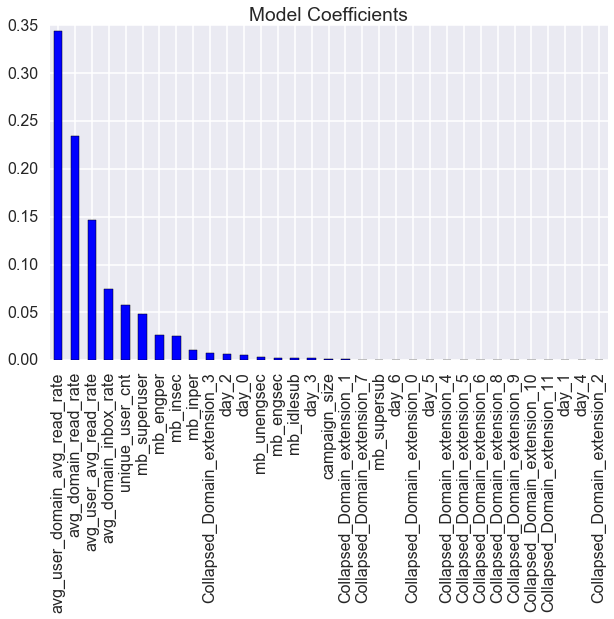

In [18]:
# Gradient Boosting Machine
exempt=['from_domain_hash', 'Domain_extension']
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline
predictors = [x for x in data.columns if x not in [target]+IDCol+exempt]
alg1= GradientBoostingRegressor(learning_rate=0.2, n_estimators=50, subsample=1.0, min_samples_split=5000, min_samples_leaf=300,
                                max_depth=5, random_state=111, max_features='auto')
modelfit(alg1,data,predictors,target,IDCol)
coef1=pd.Series(alg1.feature_importances_,predictors).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
coef1.plot(kind='bar',title='Model Coefficients')

# print coef1